## Loading

In [1]:
import os
import pathlib

import numpy as np

In [2]:
def load_data(data_dir):
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [3]:
import pandas as pd

In [4]:
data = load_data('/home/lzhu7/elvo-analysis/data/mip_three4')
labels = pd.read_csv('/home/lzhu7/elvo-analysis/data/labels_mip_three4.csv',
                     index_col='patient_id')

In [5]:
def to_arrays(data, labels):
    shuffled_ids = list(data.keys())
    np.random.shuffle(shuffled_ids)
    X_list = []
    y_list = []
    for id_ in shuffled_ids:
        X_list.append(data[id_])
        y_list.append(labels.loc[id_])
    return np.stack(X_list), np.stack(y_list)

In [6]:
x, y = to_arrays(data, labels)

In [7]:
from keras import (
    applications,
    layers,
    models,
    optimizers,
    callbacks,
    metrics,
    activations
)
from keras.preprocessing import image
from keras import backend as K

Using TensorFlow backend.
/gpfs/main/home/lzhu7/elvo-analysis/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Hack needed in order to load the model
metrics.sensitivity = sensitivity
metrics.specificity = specificity

In [10]:
# model = models.load_model('weights-3.hdf5')
model = applications.ResNet50(include_top=False, input_shape=(200, 200, 3))

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100, 100, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Evaluation

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve, auc

In [13]:
x_norm = (x - x.mean()) / x.std()

In [14]:
y_pred = model.predict(x_norm)

In [16]:
loss, acc, sens, spec = model.evaluate(x_norm, y)

868/868 [==============================] - 4s 5ms/step


In [17]:
print('loss:', loss, 'acc:', acc, 'sens:', sens, 'spec:', spec)

loss: 0.3415877729104961 acc: 0.8559907834101382 sens: 0.9068612459068475 spec: 0.7774301827777915


In [18]:
fpr, tpr, thresholds = roc_curve(y, y_pred)

In [19]:
print('auc', auc(fpr, tpr))

auc 0.9275169758565596


## Visualization

In [15]:
%matplotlib inline

In [20]:
from matplotlib import pyplot as plt

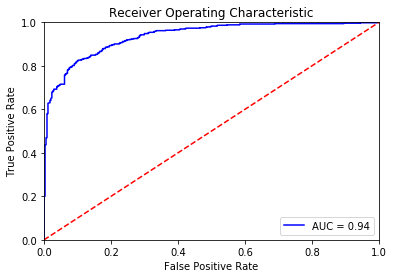

In [33]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
plt.legend(loc ='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [17]:
from vis import visualization
from vis.utils import utils

In [18]:
# Swap softmax with linear
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

/gpfs/main/home/lzhu7/elvo-analysis/venv/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


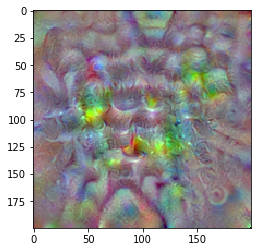

In [28]:
img = visualization.visualize_activation(model, -1, filter_indices=[20])
plt.imshow(img)

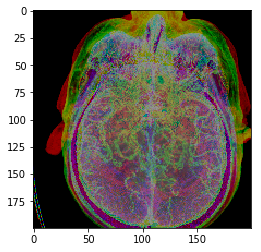

In [26]:
plt.imshow(x[0])

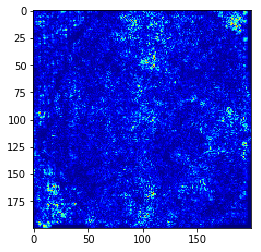

In [27]:
grads = visualization.visualize_saliency(model, -1, filter_indices=0, seed_input=x[0])
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

In [ ]:
# from quiver_engine import server

In [ ]:
# server.launch(model,
#               input_folder='/home/lzhu7/elvo-analysis/data/mip_three')